### Facet AFM -> Point Cloud Plot -> TDA

In [46]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, MeanShift

from ripser import ripser
from persim import plot_diagrams

In [22]:
def read_AFM_XYZ(filepath):
    filepath = Path(filepath)
    xyz = None
    if filepath.suffix == ".xyz" or filepath.suffix == ".XYZ":
        xyz = np.genfromtxt(filepath, skip_header=0, usecols=(0, 1, 2))
        
        # Create a mask to filter rows based on the specified conditions
        mask = [(row[0] >= 0) and (row[1] >= 0) for row in xyz]
        xyz = [list(row) for row, keep in zip(xyz, mask) if keep]
        xyz = np.array(xyz)  # Convert to a NumPy array
        norm = np.linalg.norm(xyz)
        xyz = xyz/norm
        # Sort based on the first column (x)
        xyz = xyz[xyz[:, 0].argsort()]
    return xyz

In [40]:
# Possibly not the best clustering algo for this

def determine_modal_values(point_cloud, epsilon=0.001, min_samples=5):
    z_values = point_cloud[:, 2]
    z_values = z_values.reshape(-1, 1)  # Reshape for DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(z_values)
    modal_values = np.unique(z_values[dbscan.labels_ != -1])
    modal_values = np.sort(modal_values)  # Sort the modal values
    print(modal_values)
    return modal_values

def round_noisy_points(point_cloud, modal_values):
    rounded_points = []
    for point in point_cloud:
        rounded_z = min(modal_values, key=lambda x: abs(x - point[2]))
        rounded_point = [point[0], point[1], rounded_z]
        rounded_points.append(rounded_point)
    print(rounded_points)
    return np.array(rounded_points)

In [47]:
def mean_shift(point_cloud):
    # Create a Mean Shift clustering model
    ms = MeanShift(bandwidth=bandwidth)
    
    # Fit the model to the z-values of the point cloud
    z_values = point_cloud[:, 2].reshape(-1, 1)
    ms.fit(z_values)
    
    # Determine the cluster centers (modal z-values)
    modal_values = ms.cluster_centers_.flatten()

    # Round the z-values based on the modal z-values
    rounded_points = []
    for point in point_cloud:
        closest_modal_z = min(modal_values, key=lambda z: abs(z - point[2]))
        rounded_point = [point[0], point[1], closest_modal_z]
        rounded_points.append(rounded_point)

    return np.array(rounded_points)

In [24]:
def plot_afm_3d(filtered_xyz):
    
    x, y, z = [filtered_xyz[:, i] for i in range(3)]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colormap = plt.get_cmap("viridis")

    plt.rcParams["figure.figsize"] = [3.0, 3.0]
    plt.rcParams["figure.autolayout"] = True
    
    # Normalize the 'colour' column to map it to the colormap
    norm = plt.Normalize(z.min(), z.max())

    scatter = ax.scatter(x, y, z, c=z, norm=norm, cmap=colormap, s=6)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Color Label")
    
    ax.view_init(45, 60)

    plt.tight_layout()

    plt.show()

[[3.10959090e-06 5.91022772e-03 1.85517438e-05]
 [3.10959090e-06 5.55810790e-03 3.71034875e-05]
 [3.10959090e-06 7.19442944e-03 9.27607900e-06]
 ...
 [1.21481340e-03 7.31870703e-03 9.27607900e-06]
 [1.21481340e-03 7.25656824e-03 9.27607900e-06]
 [1.21481340e-03 7.26692470e-03 9.27607900e-06]]


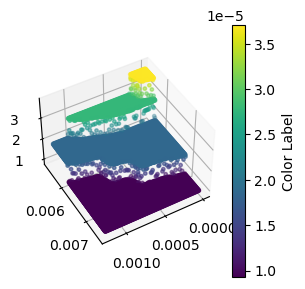

In [32]:
afm = read_AFM_XYZ('/Users/user/Documents/PhD/AFML/AFML/sample_preproc_data/terrace_sample/save-2011.11.30-14.25.48_terrace_200.xyz')
print(afm)
plot_afm_3d(afm)

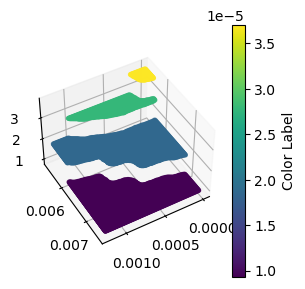

In [69]:
rounded_afm = mean_shift(afm, bandwidth=0.00000475)
plot_afm_3d(rounded_afm)

In [76]:
original_afm = read_AFM_XYZ('/Users/user/Documents/PhD/AFML/AFML/sample_preproc_data/terrace_sample/save-2011.11.30-14.25.48_terrace_IDEAL.xyz')
print(original_afm.shape)
print(afm.shape)
print(rounded_afm.shape)

(154624, 3)
(23600, 3)
(23600, 3)
